In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.3 MB/s eta 0:00:00


In [3]:
!pip3 install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 44.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.6.3
    Uninstalling typing_extensions-4.6.3:
      Successfully uninstalled typing_extensions-4.6.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fou

In [4]:
import pandas as pd
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense, concatenate
from transformers import TFBertForSequenceClassification
from keras.layers import Flatten
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Conv1D, concatenate, Flatten
from tensorflow.keras.models import Model
from transformers import TFBertModel
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Reshape

In [5]:
df_train = pd.read_csv(r'/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Dataset/KLTN/train.csv')
df_test = pd.read_csv(r'/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Dataset/KLTN/test.csv')

In [6]:
df_train['opcode'] = df_train['opcode'].astype(str)
df_test['opcode'] = df_test['opcode'].astype(str)

In [7]:
from keras.utils import to_categorical
y_train = df_train['label'].values
y_train = to_categorical(y_train)
y_test = df_test['label'].values
y_test = to_categorical(y_test)

In [8]:
## Tiền xử lý opcode
VOCAB_OP_SIZE = df_train['opcode'].nunique()
MAX_OPCODE_LENGTH = 200
EMBEDDING_SIZE = 256

In [9]:
# Khởi tạo tokenizer
tokenizer = Tokenizer(num_words=VOCAB_OP_SIZE)

# Fit tokenizer với các opcode
tokenizer.fit_on_texts(df_train['opcode'])

# Chuyển đổi các opcode thành các sequence
sequences = tokenizer.texts_to_sequences(df_train['opcode'])

# Padding các sequence để có độ dài bằng nhau
opcode_matrix = pad_sequences(sequences, maxlen=MAX_OPCODE_LENGTH)

In [10]:
## Tiền xử lý source code
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [11]:
MAX_SOURCECODE_LENGTH = 200
VOCAB_SOURCE_SIZE = df_train['source_code'].nunique()

In [12]:
# BERT model for source code
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

bert_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='source_code')
preprocessed_text = bert_preprocess(bert_input)
bert_outputs = bert_encoder(preprocessed_text)

bert_output = tf.keras.layers.Dropout(0.3, name="dropout_layer")(bert_outputs['pooled_output'])
bert_output = tf.keras.layers.Dense(64, name="bert_output")(bert_output)

In [13]:
# Model Bi-LSTM
lstm_input = Input(shape=(MAX_OPCODE_LENGTH,), dtype='int32', name='lstm_input')
lstm_layer1 = Embedding(input_dim=VOCAB_OP_SIZE, output_dim=EMBEDDING_SIZE, input_length=MAX_OPCODE_LENGTH)(lstm_input)
lstm_layer2 = Bidirectional(LSTM(units=128, return_sequences=True))(lstm_layer1)
lstm_layer3 = Dropout(0.3)(lstm_layer2)
lstm_layer4 = Bidirectional(LSTM(units=128))(lstm_layer3)
lstm_output = Dense(units=64, activation='relu')(lstm_layer4)

In [14]:
# # Model Multimodal
# dense_out_bert = Dense(64, activation='relu')(bert_output)
# dense_out_lstm = Dense(64, activation='relu')(lstm_output)
concatenated = concatenate([bert_output, lstm_output], axis=-1)
concatenated_reshaped = Reshape((128, 1))(concatenated)
conv_out = Conv1D(64, 3, activation='relu')(concatenated_reshaped)
flatten_out = Flatten()(conv_out)
dense_out = Dense(32, activation='relu')(flatten_out)
dense_out = Dropout(0.3)(dense_out)
final_out = Dense(3, activation='softmax')(dense_out)

In [15]:
from tensorflow.keras import optimizers
model = Model(inputs=[bert_input, lstm_input], outputs=final_out)

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_input (InputLayer)     [(None, 200)]                0         []                            
                                                                                                  
 source_code (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 embedding (Embedding)       (None, 200, 256)             361216    ['lstm_input[0][0]']          
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['source_code[0][0]']         
                             , 'input_word_ids': (None,                                       

In [16]:
model.fit([df_train['source_code'], opcode_matrix], y_train, epochs=30, batch_size=32)

Epoch 1/30
45/45 [==============================] - 46s 441ms/step - loss: 0.5286 - accuracy: 0.7376 - precision: 0.6510 - recall: 0.4587
Epoch 2/30
45/45 [==============================] - 19s 412ms/step - loss: 0.4094 - accuracy: 0.8273 - precision: 0.7564 - recall: 0.7110
Epoch 3/30
45/45 [==============================] - 18s 403ms/step - loss: 0.3630 - accuracy: 0.8377 - precision: 0.7742 - recall: 0.7244
Epoch 4/30
45/45 [==============================] - 18s 408ms/step - loss: 0.3610 - accuracy: 0.8481 - precision: 0.7873 - recall: 0.7456
Epoch 5/30
45/45 [==============================] - 18s 410ms/step - loss: 0.3405 - accuracy: 0.8584 - precision: 0.8056 - recall: 0.7583
Epoch 6/30
45/45 [==============================] - 18s 406ms/step - loss: 0.3272 - accuracy: 0.8629 - precision: 0.8134 - recall: 0.7640
Epoch 7/30
45/45 [==============================] - 18s 408ms/step - loss: 0.3105 - accuracy: 0.8709 - precision: 0.8272 - recall: 0.7746
Epoch 8/30
45/45 [================

In [18]:
import pickle
with open('/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Model/M1.pkl', 'wb') as file:
    pickle.dump(model, file)

In [17]:
sequences_opcode_test = tokenizer.texts_to_sequences(df_test['opcode'])
opcode_matrix_test = pad_sequences(sequences_opcode_test, maxlen=MAX_OPCODE_LENGTH)

In [18]:
y_pred = model.predict([df_test['source_code'], opcode_matrix_test], batch_size=32)

12/12 [==============================] - 6s 378ms/step


In [19]:
y_pred

array([[3.6310650e-09, 9.9999881e-01, 1.1531910e-06],
       [2.6886840e-15, 3.1910296e-14, 1.0000000e+00],
       [9.4152171e-14, 2.4823164e-13, 1.0000000e+00],
       ...,
       [4.5589194e-01, 5.3565717e-01, 8.4509160e-03],
       [2.4826780e-01, 4.7946721e-01, 2.7226496e-01],
       [1.6112902e-04, 9.9759847e-01, 2.2404243e-03]], dtype=float32)

In [20]:
import numpy as np
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_classes, y_pred_classes, digits=4))

              precision    recall  f1-score   support

           0     0.7656    0.7259    0.7452       135
           1     0.6167    0.7184    0.6637       103
           2     0.9057    0.8276    0.8649       116

    accuracy                         0.7571       354
   macro avg     0.7627    0.7573    0.7579       354
weighted avg     0.7682    0.7571    0.7607       354



In [21]:
from sklearn.metrics import accuracy_score
print("Accuracy MultiClass: ", accuracy_score(y_test_classes, y_pred_classes))

Accuracy MultiClass:  0.7570621468926554


In [22]:
# model.save('/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Model/M1')

In [22]:
model.save('saved_model/bert_mutil_data')
acc = []
pre = []
rec = []
f1 = []
for i in range(11, 31):
  print(i)
  model = tf.keras.models.load_model('saved_model/bert_mutil_data')
  model.fit([df_train['source_code'], opcode_matrix], y_train, epochs=1, batch_size=32)
  y_predicted = model.predict([df_test['source_code'], opcode_matrix_test], batch_size=32)
  y_predicted_1 = np.argmax(y_predicted, axis=1)
  y_test_1 = np.argmax(y_test, axis=1)
  metric = [i for i in classification_report(y_test_1, y_predicted_1, digits=4).split('\n')[-2].split(' ')[2:-1] if i != '']
  acc.append(round(accuracy_score(y_test_1, y_predicted_1), 4))
  pre.append(metric[0])
  rec.append(metric[1])
  f1.append(metric[2])
  model.save('saved_model/bert_mutil_data')

11
12/12 [==============================] - 6s 394ms/step
12
12/12 [==============================] - 6s 396ms/step
13
12/12 [==============================] - 7s 373ms/step
14
12/12 [==============================] - 6s 391ms/step
15
12/12 [==============================] - 7s 400ms/step
16
12/12 [==============================] - 6s 399ms/step
17
12/12 [==============================] - 6s 393ms/step
18
12/12 [==============================] - 6s 393ms/step
19
12/12 [==============================] - 7s 401ms/step
20
12/12 [==============================] - 6s 399ms/step
21
12/12 [==============================] - 6s 392ms/step
22
12/12 [==============================] - 6s 394ms/step
23
12/12 [==============================] - 7s 393ms/step
24
12/12 [==============================] - 6s 393ms/step
25
12/12 [==============================] - 6s 392ms/step
26
12/12 [==============================] - 6s 369ms/step
27
12/12 [==============================] - 7s 395ms/step
28
12/12 [====

In [23]:
for i in acc:
  print(i)

0.774
0.7825
0.7853
0.8023
0.7627
0.7655
0.7712
0.7853
0.7768
0.774
0.7825
0.7655
0.7768
0.7825
0.7966
0.7627
0.7684
0.7712
0.7797
0.7655


In [24]:
for i in pre:
  print(i)

0.7820
0.8006
0.7884
0.8168
0.7654
0.7658
0.7704
0.7954
0.7764
0.7817
0.7874
0.7789
0.7800
0.7915
0.8028
0.7690
0.7677
0.7689
0.7793
0.7632


In [25]:
for i in rec:
  print(i)

0.7740
0.7825
0.7853
0.8023
0.7627
0.7655
0.7712
0.7853
0.7768
0.7740
0.7825
0.7655
0.7768
0.7825
0.7966
0.7627
0.7684
0.7712
0.7797
0.7655


In [26]:
for i in f1:
  print(i)

0.7768
0.7860
0.7862
0.8040
0.7627
0.7616
0.7707
0.7850
0.7730
0.7755
0.7841
0.7689
0.7770
0.7856
0.7978
0.7652
0.7666
0.7688
0.7777
0.7638


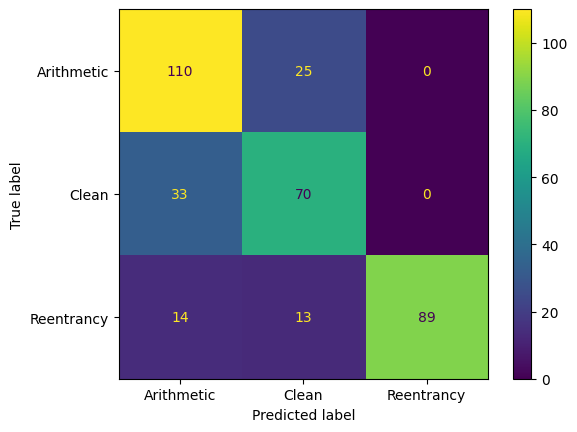

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_classes, y_pred_classes)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Arithmetic", "Clean", "Reentrancy"])

cm_display.plot()
plt.show()

In [ ]:
model.save('Multimodal/Multimodal_data2')

# Epochs 20

In [ ]:
model1 = tf.keras.models.load_model('Multimodal/Multimodal_data2')

In [ ]:
model1.fit([df_train['source_code'], opcode_matrix], y_train, epochs=10, batch_size=32)

Epoch 1/10
45/45 [==============================] - 37s 433ms/step - loss: 0.3212 - accuracy: 0.8697 - precision: 0.8270 - recall: 0.7703
Epoch 2/10
45/45 [==============================] - 19s 426ms/step - loss: 0.2941 - accuracy: 0.8766 - precision: 0.8357 - recall: 0.7837
Epoch 3/10
45/45 [==============================] - 19s 419ms/step - loss: 0.2931 - accuracy: 0.8820 - precision: 0.8446 - recall: 0.7915
Epoch 4/10
45/45 [==============================] - 19s 421ms/step - loss: 0.2775 - accuracy: 0.8876 - precision: 0.8510 - recall: 0.8035
Epoch 5/10
45/45 [==============================] - 19s 423ms/step - loss: 0.2692 - accuracy: 0.8886 - precision: 0.8568 - recall: 0.7993
Epoch 6/10
45/45 [==============================] - 19s 418ms/step - loss: 0.2743 - accuracy: 0.8855 - precision: 0.8506 - recall: 0.7965
Epoch 7/10
45/45 [==============================] - 19s 426ms/step - loss: 0.2698 - accuracy: 0.8933 - precision: 0.8661 - recall: 0.8042
Epoch 8/10
45/45 [================

In [ ]:
model1.evaluate([df_test['source_code'], opcode_matrix_test], y_test, verbose=1, batch_size=32)

12/12 [==============================] - 6s 369ms/step - loss: 0.3571 - accuracy: 0.8578 - precision: 0.7994 - recall: 0.7655


[0.3570645749568939,
 0.8578154444694519,
 0.7994100451469421,
 0.7655367255210876]

In [ ]:
y_pred = model1.predict([df_test['source_code'], opcode_matrix_test], batch_size=32)

12/12 [==============================] - 6s 395ms/step


In [ ]:
import numpy as np
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_classes, y_pred_classes, digits=4))

              precision    recall  f1-score   support

           0     0.7215    0.8444    0.7782       135
           1     0.7614    0.6505    0.7016       103
           2     0.9167    0.8534    0.8839       116

    accuracy                         0.7910       354
   macro avg     0.7998    0.7828    0.7879       354
weighted avg     0.7971    0.7910    0.7905       354



In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test_classes, y_pred_classes))

0.7909604519774012


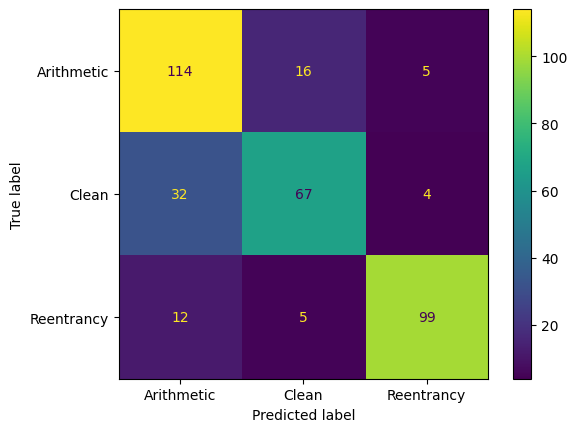

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_classes, y_pred_classes)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Arithmetic", "Clean", "Reentrancy"])

cm_display.plot()
plt.show()

In [ ]:
model1.save('Multimodal/Multimodal_data2')

# Epochs 30

In [ ]:
model2 = tf.keras.models.load_model('Multimodal/Multimodal_data2')

In [ ]:
model2.fit([df_train['source_code'], opcode_matrix], y_train, epochs=10, batch_size=32)

Epoch 1/10
45/45 [==============================] - 36s 434ms/step - loss: 0.2449 - accuracy: 0.8942 - precision: 0.8615 - recall: 0.8134
Epoch 2/10
45/45 [==============================] - 19s 415ms/step - loss: 0.2295 - accuracy: 0.9048 - precision: 0.8787 - recall: 0.8290
Epoch 3/10
45/45 [==============================] - 19s 417ms/step - loss: 0.2128 - accuracy: 0.9154 - precision: 0.8911 - recall: 0.8502
Epoch 4/10
45/45 [==============================] - 19s 416ms/step - loss: 0.2235 - accuracy: 0.9011 - precision: 0.8743 - recall: 0.8212
Epoch 5/10
45/45 [==============================] - 19s 421ms/step - loss: 0.2203 - accuracy: 0.9065 - precision: 0.8776 - recall: 0.8360
Epoch 6/10
45/45 [==============================] - 19s 427ms/step - loss: 0.1971 - accuracy: 0.9197 - precision: 0.8931 - recall: 0.8622
Epoch 7/10
45/45 [==============================] - 19s 424ms/step - loss: 0.1985 - accuracy: 0.9171 - precision: 0.8934 - recall: 0.8530
Epoch 8/10
45/45 [================

In [ ]:
y_test2 = df_test['label'].values
y_test2 = to_categorical(y_test2)

In [ ]:
model2.evaluate([df_test['source_code'], opcode_matrix_test], y_test, verbose=1, batch_size=32)

12/12 [==============================] - 7s 372ms/step - loss: 0.4600 - accuracy: 0.8522 - precision: 0.7889 - recall: 0.7599


[0.4600259065628052, 0.852165699005127, 0.7888563275337219, 0.7598869800567627]

In [ ]:
import numpy as np
y_predicted2 = model2.predict([df_test['source_code'], opcode_matrix_test], batch_size=32)
y_predicted2 = np.argmax(y_predicted2, axis=1)
y_test2 = np.argmax(y_test2, axis=1)

12/12 [==============================] - 6s 388ms/step


In [ ]:
print(classification_report(y_test2, y_predicted2))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       135
           1       0.68      0.63      0.66       103
           2       0.89      0.87      0.88       116

    accuracy                           0.78       354
   macro avg       0.77      0.77      0.77       354
weighted avg       0.78      0.78      0.78       354



In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test_classes, y_pred_classes))

0.7909604519774012


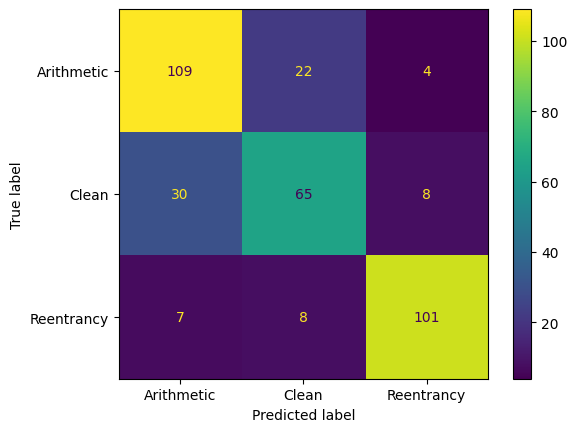

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test2, y_predicted2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Arithmetic", "Clean", "Reentrancy"])

cm_display.plot()
plt.savefig("/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Figure/KLTN/Multimodal1_30.png", dpi=1200, transparent=True)
plt.show()